<a href="https://colab.research.google.com/github/ShesterG/Stance-Detection-Ghana-2020-Elections/blob/main/Notebooks/SVM_2Classes_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine Model for Twitter Stance Analysis (2 Classes)

# Imports and Constants

In [1]:
!git clone https://github.com/ShesterG/Stance-Detection-Ghana-2020-Elections.git

%cd Stance-Detection-Ghana-2020-Elections/

fatal: destination path 'Stance-Detection-Ghana-2020-Elections' already exists and is not an empty directory.
/content/Stance-Detection-Ghana-2020-Elections


In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import ast


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import make_scorer



In [3]:
DATA_FILE_PATH = '/content/Stance-Detection-Ghana-2020-Elections/Dataset/'
CLEAN_DATA_FILE_NAME = '01EDA_All_Model_Tweets_Ghana_2020_Elections_L.csv'
TOKENIZED_DATA_FILE_NAME = '02TPP_All_Model_Tweets_Ghana_2020_Elections_L.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [4]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [5]:
df.head()

,ID,Tweet,Candidate,Stance,Preproc_Tweet,Tokens
0,2,"@NAkufoAddo H. E Nana please follow up on this FAKE NEWS, LIES and sue BBC for peddling false information. Hold alÃ¢â¬Â¦ https://t.co/SdwnMsxeUV",Nana,0.0,nana h e nana please follow up on this fake news lies and sue bbc for peddling false information hold al,"['nana', 'h', 'e', 'nana', 'pleas', 'follow', 'up', 'on', 'thi', 'fake', 'news', 'lie', 'and', 'sue', 'bbc', 'for', 'peddl', 'fals', 'inform', 'hold', 'al']"
1,6,"@ChipsJhay @TruthFreema @AOuattara_PRCI @NAkufoAddo No, you haven't. He's using his freedom of speech as it is. He's covered.",Nana,0.0,nana no you haven't he's using his freedom of speech as it is he's covered,"['nana', 'no', 'you', ""haven't"", ""he'"", 'use', 'hi', 'freedom', 'of', 'speech', 'as', 'it', 'is', ""he'"", 'cover']"
2,7,@IssahGerard @HEgyiri @NAkufoAddo Please who is this and how is he your in law??,Nana,0.0,nana please who is this and how is he your in law,"['nana', 'pleas', 'who', 'is', 'thi', 'and', 'how', 'is', 'he', 'your', 'in', 'law']"
3,17,@Kwame34580189 @bukolasaraki @NAkufoAddo Whatever.... Thought you had something there....,Nana,0.0,nana whatever thought you had something there,"['nana', 'whatev', 'thought', 'you', 'had', 'someth', 'there']"
4,18,@NAkufoAddo Remember that the good people of Gh have spoken therefore Soo be it,Nana,0.0,nana remember that the good people of gh have spoken therefore soo be it,"['nana', 'rememb', 'that', 'the', 'good', 'peopl', 'of', 'gh', 'have', 'spoken', 'therefor', 'soo', 'be', 'it']"


In [6]:
df = df[df.Stance != 0]

In [7]:
df.Tokens = df.Tokens.map(ast.literal_eval)

In [8]:
data = df[['Tokens', 'Stance']]

In [9]:
data.Stance.value_counts()

 1.0    1030
-1.0    1030
Name: Stance, dtype: int64

In [10]:
data.head()

,Tokens,Stance
803,"[nana, good, to, go, may, god, bless, an, protect, you]",1.0
804,"[mr, presid, receiv, the, grace, of, god, almighti, to, do, what, he, ha, ordain, you, for, in, jesu, mighti, name, nana]",1.0
805,"[nana, pleas, may, god, continu, to, strengthen, you, to, do, more, pleas]",1.0
806,"[nana, congratul, for, your, smooth, and, qualiti, leadership, of, thi, countri]",1.0
807,"[#ghana, s, nana, is, name, winner, of, the, report, by]",1.0


# Split Data

In [11]:
X = data['Tokens']
y = data['Stance']

# Encode Labels

In [12]:
le = LabelEncoder()

In [13]:
y_enc = le.fit_transform(y)

# Evaluate Adjustments to Minimum Document Frequency

In [14]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [15]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df, 
                                                preprocessor=passthrough, 
                                                tokenizer=passthrough)),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, 
                                         n_jobs=-1)),
                         ('SVM', SVC(kernel = 'linear', probability = True, random_state = RANDOM_STATE))
                         ])
    

    
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'f1_score' : make_scorer(f1_score, average = 'micro'), 
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro') 
              }
    
    scores = cross_validate(pipeline, X, y_enc, cv=10, scoring=scoring)
    sorted(scores.keys())

    y_pred = cross_val_predict(pipeline, X, y_enc, cv=10)

    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    conf_matrix = confusion_matrix(y_true=y_enc, y_pred=y_pred)

    classi_report = classification_report(y_true=y_enc, y_pred=y_pred, digits=4, target_names=['Negative','Postive'])
    print(classi_report)

    
    a = scores['test_accuracy'].mean()
    f = scores['test_f1_score'].mean()
    p = scores['test_precision'].mean()
    r = scores['test_recall'].mean()
    test_results = np.append(np.array([min_df, a, f, p]),r)
    
    
   
    return test_results, conf_matrix, y_pred 
    

In [16]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix, y_pred = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.8555    0.8680    0.8617      1030
     Postive     0.8660    0.8534    0.8597      1030

    accuracy                         0.8607      2060
   macro avg     0.8608    0.8607    0.8607      2060
weighted avg     0.8608    0.8607    0.8607      2060

MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative     0.8551    0.8592    0.8571      1030
     Postive     0.8585    0.8544    0.8564      1030

    accuracy                         0.8568      2060
   macro avg     0.8568    0.8568    0.8568      2060
weighted avg     0.8568    0.8568    0.8568      2060

MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative     0.8544    0.8660    0.8602      1030
     Postive     0.8642    0.8524    0.8583      1030

    accuracy                         0.8592      2060
   macro avg     0.8593    0.859

In [17]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'accuracy',
                                           'f1_score',
                                           'precision',
                                          'recall'
                                          ])

metrics_summary_df

,min doc freq,accuracy,f1_score,precision,recall
0,1.0,0.860680,0.860680,0.860680,0.860680
1,2.0,0.856796,0.856796,0.856796,0.856796
2,3.0,0.859223,0.859223,0.859223,0.859223
3,4.0,0.857767,0.857767,0.857767,0.857767
4,5.0,0.854854,0.854854,0.854854,0.854854
5,6.0,0.852913,0.852913,0.852913,0.852913
6,7.0,0.853883,0.853883,0.853883,0.853883
7,8.0,0.849515,0.849515,0.849515,0.849515
8,9.0,0.844175,0.844175,0.844175,0.844175
9,10.0,0.844175,0.844175,0.844175,0.844175


MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative     0.8555    0.8680    0.8617      1030
     Postive     0.8660    0.8534    0.8597      1030

    accuracy                         0.8607      2060
   macro avg     0.8608    0.8607    0.8607      2060
weighted avg     0.8608    0.8607    0.8607      2060



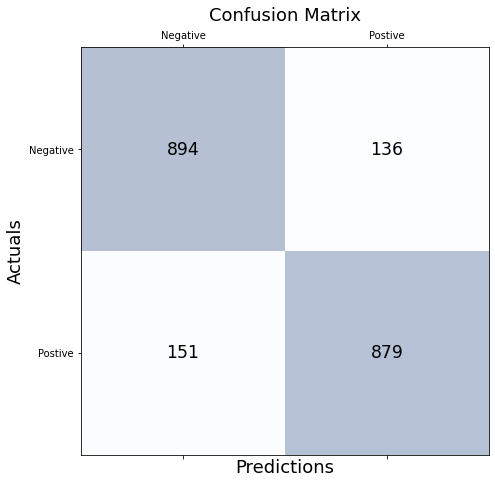

In [19]:
#Best Performace is when Minimum Document Frequency = 3 

_,conf_matrix, y_pred = train_and_eval_model(min_df=1)
labels = ['Negative', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()